In [32]:
import networkx as nx
import numpy as np
from scipy import random
import pandas as pd
import copy
import random
from collections import OrderedDict, Counter
from multiprocessing import Pool
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
def generate_my_simplicial_complex_d2(N,p1,p2):
    
    #I first generate a standard ER graph with edges connected with probability p1
    G = nx.fast_gnp_random_graph(N, p1, seed=None)
    
    if not nx.is_connected(G):
        giant = max(nx.connected_component_subgraphs(G), key=len)
        print('not connected, but GC has order ', giant.order(), 'and size', giant.size())
        G = giant

    triangles_list = []
    
    #Now I run over all the possible combinations of three elements:
    for tri in itertools.combinations(list(G.nodes()),3):
        #And I create the triangle with probability p2
        if random.random() <= p2:
            #I close the triangle.
            triangles_list.append(tri)
            
            #Now I also need to add the new links to the graph created by the triangle
            G.add_edge(tri[0], tri[1])
            G.add_edge(tri[1], tri[2])
            G.add_edge(tri[0], tri[2])
             
    #Creating a dictionary of neighbors
    node_neighbors_dict = {}
    for n in G.nodes():
        node_neighbors_dict[n] = G[n].keys()           
                
    print (len(triangles_list), 'triangles created. Size now is', G.size())

    return node_neighbors_dict, triangles_list


def draw_2d_simplicial_complex(simplices, pos=None, return_pos=False, ax = None, extra_nodes=None):
    """
    Draw a simplicial complex up to dimension 2 from a list of simplices, as in [1].
        
        Args
        ----
        simplices: list of lists of integers
            List of simplices to draw. Sub-simplices are not needed (only maximal).
            For example, the 2-simplex [1,2,3] will automatically generate the three
            1-simplices [1,2],[2,3],[1,3] and the three 0-simplices [1],[2],[3].
            When a higher order simplex is entered only its sub-simplices
            up to D=2 will be drawn.
        
        pos: dict (default=None)
            If passed, this dictionary of positions d:(x,y) is used for placing the 0-simplices.
            The standard nx spring layour is used otherwise.
           
        ax: matplotlib.pyplot.axes (default=None)
        
        return_pos: dict (default=False)
            If True returns the dictionary of positions for the 0-simplices.
            
        References
        ----------    
        .. [1] I. Iacopini, G. Petri, A. Barrat & V. Latora (2018)
               "Simplicial Models of Social Contagion".
               arXiv preprint arXiv:1810.07031..
    """

    
    #List of 0-simplices
    nodes =list(set(itertools.chain(*simplices)))
    
    #List of 1-simplices
    edges = list(set(itertools.chain(*[[tuple(sorted((i, j))) for i, j in itertools.combinations(simplex, 2)] for simplex in simplices])))

    #List of 2-simplices
    triangles = list(set(itertools.chain(*[[tuple(sorted((i, j, k))) for i, j, k in itertools.combinations(simplex, 3)] for simplex in simplices])))
    
    if ax is None: ax = plt.gca()
    ax.set_xlim([-1.1, 1.1])      
    ax.set_ylim([-1.1, 1.1])
    ax.get_xaxis().set_ticks([])  
    ax.get_yaxis().set_ticks([])
    ax.axis('off')
       
    if pos is None:
        # Creating a networkx Graph from the edgelist
        G = nx.Graph()
        G.add_edges_from(edges)
        # Creating a dictionary for the position of the nodes
        pos = nx.spring_layout(G)
        
    # Drawing the edges
    for i, j in edges:
        (x0, y0) = pos[i]
        (x1, y1) = pos[j]
        line = plt.Line2D([ x0, x1 ], [y0, y1 ],color = 'black', zorder = 1, lw=2, alpha=.4)
        ax.add_line(line);
    
    # Filling in the triangles
    for i, j, k in triangles:
        (x0, y0) = pos[i]
        (x1, y1) = pos[j]
        (x2, y2) = pos[k]
        tri = plt.Polygon([ [ x0, y0 ], [ x1, y1 ], [ x2, y2 ] ],
                          edgecolor = 'black', facecolor = plt.cm.Blues(0.6),
                          zorder = 2, alpha=0.4, lw=2)
        ax.add_patch(tri);

    # Drawing the nodes 
    if extra_nodes!=None:
        nodes.extend(extra_nodes);
        nodes = list(set(nodes))
    for i in nodes:
        (x, y) = pos[i]
        circ = plt.Circle([ x, y ], radius = 0.05, zorder = 3, lw=0.5,
                          edgecolor = 'Black', facecolor = u'#ff7f0e')
        ax.add_patch(circ);

    if return_pos: return pos

In [34]:
def get_p1_and_p2_correction(k1,k2,N):
    p2 = (2.*k2)/((N-1.)*(N-2.))
    p1 = (k1 - 2.*k2)/((N-1.)- 2.*k2)
    if (p1>=0) and (p2>=0):
        return p1, p2
    else:
        raise ValueError('Negative probability!')
        
def one_realization(ii):
    print('ITERATION %i'%ii)
    
    #Generating a simplicial complex with the given parameters
    node_neighbors_dict, triangles_list = generate_my_simplicial_complex_d2(N,p1,p2)

    return node_neighbors_dict, triangles_list
    
def parse_results(results):
    
    degree_list = []
    tri_degree_list = []
    
    for res in results:
        node_neighbors_dict, triangles_list = res
        
        #Adding the degree sequence of this realization to the global list
        degree_list += [len(neighs[1]) for neighs in node_neighbors_dict.items()]
    
        #creating a triangles degree sequence and adding it to the global list
        vertex_in_a_triangle = []
        for tri in triangles_list:
            vertex_in_a_triangle += tri
            
        tri_degree_list += Counter(vertex_in_a_triangle).values()

    degree_counter = Counter(degree_list)
    triangle_degree_counter = Counter(tri_degree_list)

    return degree_counter, triangle_degree_counter

not connected, but GC has order  39 and size 59
46 triangles created. Size now is 175


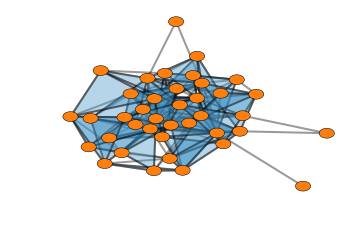

In [37]:
k1, k2, N = 10, 4, 40
p1, p2 = get_p1_and_p2_correction(k1, k2, N)
node_neighbors_dict, triangles_list = generate_my_simplicial_complex_d2(N,p1,p2)
simplices = []
for n in node_neighbors_dict:
    for nn in node_neighbors_dict[n]:
        simplices.append([n,nn])
simplices.extend(triangles_list)

draw_2d_simplicial_complex(simplices)

Running in parallel

In [ ]:
#Simplicial Complex
N = 2000
k1 = 20
k2 = 6
p1, p2 = get_p1_and_p2_correction(k1,k2,N)

n_simulations = 80

#################################################

iteration_numbers = range(n_simulations)

pool = Pool(8)                         
results = pool.map(one_realization, iteration_numbers)

In [22]:
degree_counter, triangle_degree_counter = parse_results(results)

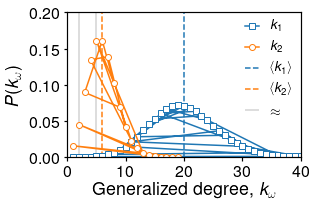

In [23]:
plt.rcParams['text.usetex'] = True 
plt.rcParams['text.latex.preamble'] = [r'\usepackage[helvet]{sfmath}']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'helvetica'

fig = plt.figure(figsize=(4.5,3));
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2

ax = plt.subplot(111)

norm_k1 = 1.*np.array(list(degree_counter.values()))/sum(list(degree_counter.values()))
norm_k2 = 1.*np.array(list(triangle_degree_counter.values()))/sum(list(triangle_degree_counter.values()))

#################### plot pdf
ax.plot(degree_counter.keys(), norm_k1, 's-', label='$k_1$',
        clip_on=True, mfc='white');
ax.plot(triangle_degree_counter.keys(), norm_k2, 'o-', label='$k_2$',
        clip_on=True, mfc='white');


#################### real mean
sum_of_numbers = sum(number*count for number, count in degree_counter.items())
count = sum(count for n, count in degree_counter.items())
mean_k1 = float(sum_of_numbers) / count

sum_of_numbers = sum(number*count for number, count in triangle_degree_counter.items())
count = sum(count for n, count in triangle_degree_counter.items())
mean_k2 = float(sum_of_numbers) / count

ax.vlines(mean_k1,0,0.2, linewidth=1.5, linestyles='--',
          color=u'#1f77b4', label=r'$\langle k_1 \rangle$');
ax.vlines(mean_k2,0,0.2, linewidth=1.5, linestyles='--',
          color=u'#ff7f0e', label=r'$\langle k_2 \rangle$');

#################### expected mean
ax.vlines(k2,0,0.2, linewidth=1.5, linestyles='-', color='lightgray', zorder=1, label=r'$\approx$');
ax.vlines(k1,0,0.2, linewidth=1.5, linestyles='-', color='lightgray', zorder=1);

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('Generalized degree, $k_\omega$', size=18)
ax.set_ylabel('$P(k_\omega)$', size=18)

ax.set_ylim(0,0.2);
ax.set_xlim(0,40);

plt.legend(fontsize=14, loc='upper right', handlelength=1, frameon=False, borderpad=0)

plt.tight_layout()